In [129]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from gensim.models import Word2Vec
import gensim.downloader as api
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [73]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [74]:
df.drop('id',axis=1,inplace=True) 

In [75]:
df.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data Preprocessing

In [76]:
for column in ['keyword', 'location']:
    mode_value = df[column].mode()[0]
    df[column].fillna(mode_value,inplace=True)

In [77]:
# Removing special characters, URLs, and HTML tags.
def clean_tweet(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters, numbers, punctuations except for hashtags and @mentions
    text = re.sub(r'[^A-Za-z0-9\s@#]', '', text)
    return text


df['keyword'] = df['keyword'].apply(clean_tweet)
df['location'] = df['location'].apply(clean_tweet)
df['text'] = df['text'].apply(clean_tweet)

In [78]:
# converting to lowercase, removing stopwords, and applying stemming or lemmatization.
categorical_text_columns = df.select_dtypes(include=['O']).columns
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
ps = PorterStemmer()
lemma = WordNetLemmatizer()
for column in categorical_text_columns:
    processed_column = []
    for text in df[column]:
        text = text.lower()
        text = nltk.word_tokenize(text)
        text = [ps.stem(word) for word in text if word not in all_stopwords]
        text = [lemma.lemmatize(word) for word in text if word not in all_stopwords]
        processed_column.append(" ".join(text))
    df[column] = processed_column

# Feature Extraction

In [79]:
X = df.drop('target',axis=1)
y = df['target']
model = api.load('word2vec-google-news-300')

In [80]:
def get_average_word2vec(text, model, vector_size=300):
    
    tokens = nltk.word_tokenize(text)
    
    word_vecs = [model[word] for word in tokens if word in model]
    
    if len(word_vecs) == 0:
        return np.zeros(vector_size)
    else:
        return np.mean(word_vecs, axis=0)

In [81]:
embedding_columns = []
for column in categorical_text_columns:
    embeddings = X[column].apply(lambda x: get_average_word2vec(x, model))
    embeddings_df = pd.DataFrame(embeddings.tolist(), columns=[f"{column}_embedding_{i}" for i in range(model.vector_size)])
    embedding_columns.append(embeddings_df)
    
X_embeddings = pd.concat([X.drop(categorical_text_columns, axis=1)] + embedding_columns, axis=1)

# Model Training, Selection, and Model Evaluation

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

### Neural Network model 

In [94]:
# Determine best number of hidden layers
for n in [10,50,100,500,800]:
    model = Sequential()
    model.add(layers.Input(shape = (X_train.shape[1],)))
    model.add(layers.Dense(n,activation='relu',name='Hidden_layer'))
    model.add(layers.Dense(1,activation='sigmoid',name='Output_layer'))
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs= 50,batch_size = 20)
    print(f"For {n}: {model.evaluate(X_test,y_test)}")

Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5301 - loss: 0.6905 - val_accuracy: 0.5890 - val_loss: 0.6779
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.5946 - loss: 0.6723 - val_accuracy: 0.6139 - val_loss: 0.6635
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.6246 - loss: 0.6584 - val_accuracy: 0.6323 - val_loss: 0.6475
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.6536 - loss: 0.6382 - val_accuracy: 0.6901 - val_loss: 0.6321
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.7009 - loss: 0.6184 - val_accuracy: 0.7111 - val_loss: 0.6152
Epoch 6/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.7277 - loss: 0.5997 - val_accuracy: 0.7242 - val_loss: 0.5991
Epoch 7/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.7501 - loss: 0.5766 - val_accuracy: 0.7367 - val_loss: 0.5849
Epoch 8/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7439 - loss: 0.5695 - val_

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.7762 - loss: 0.5046
For 10: [0.5126609802246094, 0.7642810344696045]
Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5570 - loss: 0.6852 - val_accuracy: 0.5850 - val_loss: 0.6685
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.5713 - loss: 0.6661 - val_accuracy: 0.6205 - val_loss: 0.6538
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6350 - loss: 0.6410 - val_accuracy: 0.6592 - val_loss: 0.6376
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.6566 - loss: 0.6290 - val_accuracy: 0.6783 - val_loss: 0.6207
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7034 - loss: 0.6112 - val_accuracy: 0.7104 - val_loss: 0.6048
Epoch 6/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7245 - loss: 0.5925 - val_accuracy: 0.7236 - val_loss: 0.5922
Epoch 7/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7341 - loss: 0.5775 - val_accuracy: 0.

Epoch 50/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.8115 - loss: 0.4150 - val_accuracy: 0.7676 - val_loss: 0.5074
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.7771 - loss: 0.4996
For 50: [0.5074212551116943, 0.7675639986991882]
Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5559 - loss: 0.6832 - val_accuracy: 0.5732 - val_loss: 0.6668
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5893 - loss: 0.6601 - val_accuracy: 0.5949 - val_loss: 0.6500
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6273 - loss: 0.6415 - val_accuracy: 0.6625 - val_loss: 0.6325
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6865 - loss: 0.6198 - val_accuracy: 0.6881 - val_loss: 0.6144
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7171 - loss: 0.6025 - val_accuracy: 0.7065 - val_loss: 0.5974
Epoch 6/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7291 - loss: 0.5848 - val_accuracy: 0.7

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8136 - loss: 0.4237 - val_accuracy: 0.7761 - val_loss: 0.4994
Epoch 50/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8266 - loss: 0.4116 - val_accuracy: 0.7695 - val_loss: 0.4975
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.7800 - loss: 0.4919
For 100: [0.4974854588508606, 0.7695338129997253]
Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5480 - loss: 0.6814 - val_accuracy: 0.5831 - val_loss: 0.6606
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5900 - loss: 0.6536 - val_accuracy: 0.6710 - val_loss: 0.6444
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6738 - loss: 0.6331 - val_accuracy: 0.6802 - val_loss: 0.6242
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7051 - loss: 0.6115 - val_accuracy: 0.7216 - val_loss: 0.6076
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7326 - loss: 0.5931 - val_accuracy: 0.7282 - val_lo

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8116 - loss: 0.4214 - val_accuracy: 0.7774 - val_loss: 0.5000
Epoch 49/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8210 - loss: 0.4125 - val_accuracy: 0.7722 - val_loss: 0.5011
Epoch 50/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8223 - loss: 0.4090 - val_accuracy: 0.7689 - val_loss: 0.5040
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.7826 - loss: 0.4968
For 500: [0.5040414333343506, 0.7688772082328796]
Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5508 - loss: 0.6859 - val_accuracy: 0.5850 - val_loss: 0.6641
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5842 - loss: 0.6584 - val_accuracy: 0.6376 - val_loss: 0.6459
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6466 - loss: 0.6339 - val_accuracy: 0.6980 - val_loss: 0.6284
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6885 - loss: 0.6167 - val_accuracy: 0.7111 - val_l

305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8196 - loss: 0.3975 - val_accuracy: 0.7722 - val_loss: 0.4949
Epoch 48/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8289 - loss: 0.4081 - val_accuracy: 0.7781 - val_loss: 0.4952
Epoch 49/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8246 - loss: 0.4035 - val_accuracy: 0.7708 - val_loss: 0.4959
Epoch 50/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8392 - loss: 0.3891 - val_accuracy: 0.7676 - val_loss: 0.5012
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.7833 - loss: 0.4934
For 800: [0.5011664628982544, 0.7675639986991882]


#### For 10: [0.5126609802246094, 0.7642810344696045]
#### For 50: [0.5074212551116943, 0.7675639986991882]
#### For 100: [0.4974854588508606, 0.7695338129997253]
#### For 500: [0.5040414333343506, 0.7688772082328796]
#### For 800: [0.5011664628982544, 0.7675639986991882]
#### So 100 is the best option

In [95]:
# Determine the best number of epochs
for n in [10,50,100,500,1000]:
    model = Sequential()
    model.add(layers.Input(shape = (X_train.shape[1],)))
    model.add(layers.Dense(100,activation='relu',name='Hidden_layer'))
    model.add(layers.Dense(1,activation='sigmoid',name='Output_layer'))
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs= n, batch_size = 20)
    print(f"For {n}: {model.evaluate(X_test,y_test)}")

Epoch 1/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5581 - loss: 0.6823 - val_accuracy: 0.5824 - val_loss: 0.6631
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5989 - loss: 0.6556 - val_accuracy: 0.6290 - val_loss: 0.6460
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6453 - loss: 0.6386 - val_accuracy: 0.6507 - val_loss: 0.6287
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6810 - loss: 0.6185 - val_accuracy: 0.6914 - val_loss: 0.6118
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7150 - loss: 0.5970 - val_accuracy: 0.7058 - val_loss: 0.5957
Epoch 6/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7311 - loss: 0.5775 - val_accuracy: 0.7229 - val_loss: 0.5816
Epoch 7/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7401 - loss: 0.5682 - val_accuracy: 0.7420 - val_loss: 0.5688
Epoch 8/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7450 - loss: 0.5569 - val_accuracy: 0.

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8080 - loss: 0.4275 - val_accuracy: 0.7623 - val_loss: 0.5057
Epoch 41/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8094 - loss: 0.4279 - val_accuracy: 0.7735 - val_loss: 0.4973
Epoch 42/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8157 - loss: 0.4208 - val_accuracy: 0.7787 - val_loss: 0.5022
Epoch 43/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8161 - loss: 0.4215 - val_accuracy: 0.7439 - val_loss: 0.5273
Epoch 44/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8151 - loss: 0.4150 - val_accuracy: 0.7735 - val_loss: 0.4986
Epoch 45/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8152 - loss: 0.4158 - val_accuracy: 0.7748 - val_loss: 0.4970
Epoch 46/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8145 - loss: 0.4224 - val_accuracy: 0.7748 - val_loss: 0.4986
Epoch 47/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8119 - loss: 0.4249 - val_accuracy: 0.7741

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8216 - loss: 0.4215 - val_accuracy: 0.7695 - val_loss: 0.5064
Epoch 40/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8173 - loss: 0.4257 - val_accuracy: 0.7787 - val_loss: 0.4999
Epoch 41/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8174 - loss: 0.4236 - val_accuracy: 0.7814 - val_loss: 0.4975
Epoch 42/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8154 - loss: 0.4299 - val_accuracy: 0.7761 - val_loss: 0.4989
Epoch 43/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8229 - loss: 0.4121 - val_accuracy: 0.7846 - val_loss: 0.5013
Epoch 44/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8176 - loss: 0.4235 - val_accuracy: 0.7623 - val_loss: 0.5173
Epoch 45/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8148 - loss: 0.4247 - val_accuracy: 0.7807 - val_loss: 0.4999
Epoch 46/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8306 - loss: 0.4002 - val_accuracy:

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8390 - loss: 0.3725 - val_accuracy: 0.7794 - val_loss: 0.5133
Epoch 90/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0.3699 - val_accuracy: 0.7807 - val_loss: 0.5139
Epoch 91/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8497 - loss: 0.3602 - val_accuracy: 0.7794 - val_loss: 0.5137
Epoch 92/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8378 - loss: 0.3672 - val_accuracy: 0.7807 - val_loss: 0.5146
Epoch 93/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8421 - loss: 0.3703 - val_accuracy: 0.7774 - val_loss: 0.5134
Epoch 94/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8452 - loss: 0.3638 - val_accuracy: 0.7722 - val_loss: 0.5209
Epoch 95/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8366 - loss: 0.3685 - val_accuracy: 0.7715 - val_loss: 0.5194
Epoch 96/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8500 - loss: 0.3570 - val_accuracy:

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8137 - loss: 0.4296 - val_accuracy: 0.7702 - val_loss: 0.5024
Epoch 39/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8109 - loss: 0.4294 - val_accuracy: 0.7748 - val_loss: 0.4988
Epoch 40/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8196 - loss: 0.4253 - val_accuracy: 0.7761 - val_loss: 0.5006
Epoch 41/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8154 - loss: 0.4268 - val_accuracy: 0.7735 - val_loss: 0.5015
Epoch 42/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8143 - loss: 0.4199 - val_accuracy: 0.7728 - val_loss: 0.5019
Epoch 43/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8164 - loss: 0.4137 - val_accuracy: 0.7781 - val_loss: 0.4990
Epoch 44/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8163 - loss: 0.4165 - val_accuracy: 0.7761 - val_loss: 0.4973
Epoch 45/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8093 - loss: 0.4291 - val_accuracy:

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8302 - loss: 0.3912 - val_accuracy: 0.7663 - val_loss: 0.5150
Epoch 89/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8418 - loss: 0.3662 - val_accuracy: 0.7597 - val_loss: 0.5181
Epoch 90/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8328 - loss: 0.3892 - val_accuracy: 0.7728 - val_loss: 0.5109
Epoch 91/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8402 - loss: 0.3746 - val_accuracy: 0.7564 - val_loss: 0.5243
Epoch 92/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8420 - loss: 0.3661 - val_accuracy: 0.7715 - val_loss: 0.5167
Epoch 93/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8355 - loss: 0.3765 - val_accuracy: 0.7702 - val_loss: 0.5129
Epoch 94/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8408 - loss: 0.3741 - val_accuracy: 0.7676 - val_loss: 0.5121
Epoch 95/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8495 - loss: 0.3593 - val_accuracy:

Epoch 138/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8581 - loss: 0.3346 - val_accuracy: 0.7741 - val_loss: 0.5324
Epoch 139/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8728 - loss: 0.3105 - val_accuracy: 0.7682 - val_loss: 0.5370
Epoch 140/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8648 - loss: 0.3308 - val_accuracy: 0.7728 - val_loss: 0.5318
Epoch 141/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8629 - loss: 0.3268 - val_accuracy: 0.7682 - val_loss: 0.5445
Epoch 142/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8702 - loss: 0.3193 - val_accuracy: 0.7735 - val_loss: 0.5317
Epoch 143/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8695 - loss: 0.3272 - val_accuracy: 0.7748 - val_loss: 0.5327
Epoch 144/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8689 - loss: 0.3167 - val_accuracy: 0.7557 - val_loss: 0.5498
Epoch 145/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8705 - loss: 0

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8812 - loss: 0.2909 - val_accuracy: 0.7715 - val_loss: 0.5601
Epoch 188/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8912 - loss: 0.2775 - val_accuracy: 0.7741 - val_loss: 0.5588
Epoch 189/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8966 - loss: 0.2709 - val_accuracy: 0.7741 - val_loss: 0.5592
Epoch 190/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8902 - loss: 0.2837 - val_accuracy: 0.7518 - val_loss: 0.5674
Epoch 191/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8935 - loss: 0.2792 - val_accuracy: 0.7708 - val_loss: 0.5579
Epoch 192/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8923 - loss: 0.2765 - val_accuracy: 0.7722 - val_loss: 0.5633
Epoch 193/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8822 - loss: 0.2846 - val_accuracy: 0.7715 - val_loss: 0.5685
Epoch 194/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8906 - loss: 0.2757 - val_ac

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9149 - loss: 0.2271 - val_accuracy: 0.7715 - val_loss: 0.5854
Epoch 237/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9121 - loss: 0.2430 - val_accuracy: 0.7531 - val_loss: 0.5965
Epoch 238/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9196 - loss: 0.2292 - val_accuracy: 0.7643 - val_loss: 0.5896
Epoch 239/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9192 - loss: 0.2254 - val_accuracy: 0.7590 - val_loss: 0.5938
Epoch 240/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9156 - loss: 0.2343 - val_accuracy: 0.7708 - val_loss: 0.5902
Epoch 241/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9196 - loss: 0.2280 - val_accuracy: 0.7708 - val_loss: 0.5944
Epoch 242/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9188 - loss: 0.2292 - val_accuracy: 0.7590 - val_loss: 0.5948
Epoch 243/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9213 - loss: 0.2288 - val_ac

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9247 - loss: 0.2026 - val_accuracy: 0.7656 - val_loss: 0.6464
Epoch 286/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9309 - loss: 0.2008 - val_accuracy: 0.7708 - val_loss: 0.6261
Epoch 287/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9341 - loss: 0.1922 - val_accuracy: 0.7676 - val_loss: 0.6198
Epoch 288/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9352 - loss: 0.1885 - val_accuracy: 0.7511 - val_loss: 0.6330
Epoch 289/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9305 - loss: 0.1976 - val_accuracy: 0.7617 - val_loss: 0.6257
Epoch 290/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9318 - loss: 0.1931 - val_accuracy: 0.7741 - val_loss: 0.6309
Epoch 291/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9334 - loss: 0.1879 - val_accuracy: 0.7610 - val_loss: 0.6279
Epoch 292/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9320 - loss: 0.1943 - val_ac

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9409 - loss: 0.1727 - val_accuracy: 0.7669 - val_loss: 0.6586
Epoch 335/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9532 - loss: 0.1562 - val_accuracy: 0.7715 - val_loss: 0.6594
Epoch 336/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9517 - loss: 0.1533 - val_accuracy: 0.7649 - val_loss: 0.6621
Epoch 337/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9449 - loss: 0.1614 - val_accuracy: 0.7702 - val_loss: 0.6581
Epoch 338/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9492 - loss: 0.1590 - val_accuracy: 0.7689 - val_loss: 0.6605
Epoch 339/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9457 - loss: 0.1653 - val_accuracy: 0.7623 - val_loss: 0.6575
Epoch 340/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9456 - loss: 0.1587 - val_accuracy: 0.7722 - val_loss: 0.6721
Epoch 341/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9563 - loss: 0.1518 - val_ac

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9598 - loss: 0.1358 - val_accuracy: 0.7413 - val_loss: 0.7162
Epoch 384/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9588 - loss: 0.1354 - val_accuracy: 0.7649 - val_loss: 0.6965
Epoch 385/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9587 - loss: 0.1343 - val_accuracy: 0.7643 - val_loss: 0.7014
Epoch 386/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9568 - loss: 0.1335 - val_accuracy: 0.7715 - val_loss: 0.7150
Epoch 387/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9575 - loss: 0.1399 - val_accuracy: 0.7564 - val_loss: 0.6959
Epoch 388/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9586 - loss: 0.1359 - val_accuracy: 0.7564 - val_loss: 0.6974
Epoch 389/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9623 - loss: 0.1321 - val_accuracy: 0.7689 - val_loss: 0.7011
Epoch 390/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9586 - loss: 0.1335 - val_ac

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9645 - loss: 0.1222 - val_accuracy: 0.7544 - val_loss: 0.7349
Epoch 433/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9657 - loss: 0.1155 - val_accuracy: 0.7636 - val_loss: 0.7257
Epoch 434/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9681 - loss: 0.1150 - val_accuracy: 0.7466 - val_loss: 0.7457
Epoch 435/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9652 - loss: 0.1148 - val_accuracy: 0.7564 - val_loss: 0.7392
Epoch 436/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9665 - loss: 0.1158 - val_accuracy: 0.7689 - val_loss: 0.7336
Epoch 437/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9672 - loss: 0.1169 - val_accuracy: 0.7643 - val_loss: 0.7326
Epoch 438/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9681 - loss: 0.1108 - val_accuracy: 0.7597 - val_loss: 0.7339
Epoch 439/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9647 - loss: 0.1126 - val_ac

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9681 - loss: 0.1036 - val_accuracy: 0.7439 - val_loss: 0.7879
Epoch 482/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9703 - loss: 0.1024 - val_accuracy: 0.7636 - val_loss: 0.7644
Epoch 483/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9703 - loss: 0.1022 - val_accuracy: 0.7669 - val_loss: 0.7671
Epoch 484/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9690 - loss: 0.1055 - val_accuracy: 0.7406 - val_loss: 0.8052
Epoch 485/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9730 - loss: 0.0961 - val_accuracy: 0.7728 - val_loss: 0.7690
Epoch 486/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9735 - loss: 0.0963 - val_accuracy: 0.7577 - val_loss: 0.7754
Epoch 487/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9713 - loss: 0.0991 - val_accuracy: 0.7682 - val_loss: 0.7740
Epoch 488/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9732 - loss: 0.0995 - val_ac

Epoch 30/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8071 - loss: 0.4423 - val_accuracy: 0.7866 - val_loss: 0.4963
Epoch 31/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7891 - loss: 0.4556 - val_accuracy: 0.7879 - val_loss: 0.4962
Epoch 32/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8082 - loss: 0.4370 - val_accuracy: 0.7879 - val_loss: 0.4959
Epoch 33/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7964 - loss: 0.4403 - val_accuracy: 0.7853 - val_loss: 0.4955
Epoch 34/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8038 - loss: 0.4439 - val_accuracy: 0.7735 - val_loss: 0.5049
Epoch 35/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8067 - loss: 0.4331 - val_accuracy: 0.7781 - val_loss: 0.4981
Epoch 36/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8042 - loss: 0.4350 - val_accuracy: 0.7866 - val_loss: 0.4963
Epoch 37/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8064 - loss: 0

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8296 - loss: 0.3854 - val_accuracy: 0.7794 - val_loss: 0.5057
Epoch 80/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8359 - loss: 0.3749 - val_accuracy: 0.7761 - val_loss: 0.5082
Epoch 81/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8342 - loss: 0.3876 - val_accuracy: 0.7761 - val_loss: 0.5084
Epoch 82/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8325 - loss: 0.3837 - val_accuracy: 0.7754 - val_loss: 0.5106
Epoch 83/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8281 - loss: 0.3929 - val_accuracy: 0.7735 - val_loss: 0.5131
Epoch 84/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8393 - loss: 0.3722 - val_accuracy: 0.7728 - val_loss: 0.5104
Epoch 85/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8395 - loss: 0.3819 - val_accuracy: 0.7781 - val_loss: 0.5075
Epoch 86/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8376 - loss: 0.3807 - val_ac

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8601 - loss: 0.3478 - val_accuracy: 0.7708 - val_loss: 0.5317
Epoch 129/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8646 - loss: 0.3319 - val_accuracy: 0.7479 - val_loss: 0.5539
Epoch 130/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8561 - loss: 0.3454 - val_accuracy: 0.7695 - val_loss: 0.5296
Epoch 131/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8587 - loss: 0.3385 - val_accuracy: 0.7722 - val_loss: 0.5312
Epoch 132/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8694 - loss: 0.3240 - val_accuracy: 0.7748 - val_loss: 0.5304
Epoch 133/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8617 - loss: 0.3320 - val_accuracy: 0.7649 - val_loss: 0.5374
Epoch 134/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8607 - loss: 0.3327 - val_accuracy: 0.7617 - val_loss: 0.5368
Epoch 135/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8689 - loss: 0.3229 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8878 - loss: 0.2880 - val_accuracy: 0.7669 - val_loss: 0.5511
Epoch 178/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8878 - loss: 0.2856 - val_accuracy: 0.7682 - val_loss: 0.5518
Epoch 179/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8929 - loss: 0.2817 - val_accuracy: 0.7689 - val_loss: 0.5599
Epoch 180/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8937 - loss: 0.2757 - val_accuracy: 0.7708 - val_loss: 0.5534
Epoch 181/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8906 - loss: 0.2804 - val_accuracy: 0.7702 - val_loss: 0.5495
Epoch 182/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8940 - loss: 0.2762 - val_accuracy: 0.7656 - val_loss: 0.5537
Epoch 183/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8907 - loss: 0.2797 - val_accuracy: 0.7656 - val_loss: 0.5786
Epoch 184/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8892 - loss: 0.2873 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9110 - loss: 0.2445 - val_accuracy: 0.7420 - val_loss: 0.6075
Epoch 227/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9072 - loss: 0.2487 - val_accuracy: 0.7669 - val_loss: 0.5844
Epoch 228/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9161 - loss: 0.2394 - val_accuracy: 0.7682 - val_loss: 0.5782
Epoch 229/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9121 - loss: 0.2455 - val_accuracy: 0.7676 - val_loss: 0.5817
Epoch 230/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9108 - loss: 0.2415 - val_accuracy: 0.7663 - val_loss: 0.5836
Epoch 231/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9087 - loss: 0.2417 - val_accuracy: 0.7420 - val_loss: 0.6073
Epoch 232/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9108 - loss: 0.2411 - val_accuracy: 0.7282 - val_loss: 0.6378
Epoch 233/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9088 - loss: 0.2453 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9305 - loss: 0.1988 - val_accuracy: 0.7682 - val_loss: 0.6337
Epoch 276/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9275 - loss: 0.2003 - val_accuracy: 0.7669 - val_loss: 0.6211
Epoch 277/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9351 - loss: 0.1952 - val_accuracy: 0.7420 - val_loss: 0.6373
Epoch 278/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9286 - loss: 0.2027 - val_accuracy: 0.7623 - val_loss: 0.6189
Epoch 279/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9247 - loss: 0.2040 - val_accuracy: 0.7656 - val_loss: 0.6183
Epoch 280/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9328 - loss: 0.1982 - val_accuracy: 0.7669 - val_loss: 0.6325
Epoch 281/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9304 - loss: 0.1982 - val_accuracy: 0.7649 - val_loss: 0.6203
Epoch 282/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9323 - loss: 0.1945 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9469 - loss: 0.1661 - val_accuracy: 0.7564 - val_loss: 0.6531
Epoch 325/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9482 - loss: 0.1694 - val_accuracy: 0.7656 - val_loss: 0.6540
Epoch 326/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9421 - loss: 0.1691 - val_accuracy: 0.7603 - val_loss: 0.6515
Epoch 327/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9497 - loss: 0.1650 - val_accuracy: 0.7656 - val_loss: 0.6505
Epoch 328/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9443 - loss: 0.1724 - val_accuracy: 0.7643 - val_loss: 0.6568
Epoch 329/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9500 - loss: 0.1645 - val_accuracy: 0.7649 - val_loss: 0.6518
Epoch 330/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9450 - loss: 0.1688 - val_accuracy: 0.7603 - val_loss: 0.6572
Epoch 331/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9500 - loss: 0.1635 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9596 - loss: 0.1402 - val_accuracy: 0.7623 - val_loss: 0.6860
Epoch 374/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9555 - loss: 0.1402 - val_accuracy: 0.7636 - val_loss: 0.6924
Epoch 375/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9568 - loss: 0.1482 - val_accuracy: 0.7643 - val_loss: 0.6967
Epoch 376/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9597 - loss: 0.1448 - val_accuracy: 0.7663 - val_loss: 0.6931
Epoch 377/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9576 - loss: 0.1417 - val_accuracy: 0.7643 - val_loss: 0.6919
Epoch 378/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9628 - loss: 0.1346 - val_accuracy: 0.7636 - val_loss: 0.6970
Epoch 379/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9546 - loss: 0.1396 - val_accuracy: 0.7498 - val_loss: 0.7034
Epoch 380/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9550 - loss: 0.1406 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9665 - loss: 0.1204 - val_accuracy: 0.7557 - val_loss: 0.7295
Epoch 423/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9627 - loss: 0.1256 - val_accuracy: 0.7571 - val_loss: 0.7276
Epoch 424/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9647 - loss: 0.1226 - val_accuracy: 0.7630 - val_loss: 0.7280
Epoch 425/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9618 - loss: 0.1225 - val_accuracy: 0.7630 - val_loss: 0.7350
Epoch 426/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9660 - loss: 0.1171 - val_accuracy: 0.7328 - val_loss: 0.7518
Epoch 427/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9629 - loss: 0.1242 - val_accuracy: 0.7538 - val_loss: 0.7364
Epoch 428/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9630 - loss: 0.1192 - val_accuracy: 0.7557 - val_loss: 0.7344
Epoch 429/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9631 - loss: 0.1195 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9707 - loss: 0.1040 - val_accuracy: 0.7630 - val_loss: 0.7740
Epoch 472/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9707 - loss: 0.1037 - val_accuracy: 0.7623 - val_loss: 0.7781
Epoch 473/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9688 - loss: 0.1011 - val_accuracy: 0.7525 - val_loss: 0.7619
Epoch 474/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9703 - loss: 0.1043 - val_accuracy: 0.7610 - val_loss: 0.7668
Epoch 475/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9677 - loss: 0.1057 - val_accuracy: 0.7124 - val_loss: 0.8786
Epoch 476/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9674 - loss: 0.1123 - val_accuracy: 0.7531 - val_loss: 0.7704
Epoch 477/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9687 - loss: 0.1069 - val_accuracy: 0.7636 - val_loss: 0.7746
Epoch 478/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9665 - loss: 0.1082 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9706 - loss: 0.0946 - val_accuracy: 0.7649 - val_loss: 0.8146
Epoch 521/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9714 - loss: 0.0940 - val_accuracy: 0.7380 - val_loss: 0.8093
Epoch 522/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9739 - loss: 0.0892 - val_accuracy: 0.7630 - val_loss: 0.8131
Epoch 523/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9760 - loss: 0.0904 - val_accuracy: 0.7538 - val_loss: 0.7976
Epoch 524/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9749 - loss: 0.0917 - val_accuracy: 0.7485 - val_loss: 0.8103
Epoch 525/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9758 - loss: 0.0884 - val_accuracy: 0.7498 - val_loss: 0.8063
Epoch 526/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9741 - loss: 0.0874 - val_accuracy: 0.7505 - val_loss: 0.8085
Epoch 527/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9749 - loss: 0.0933 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9759 - loss: 0.0816 - val_accuracy: 0.7380 - val_loss: 0.8488
Epoch 570/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9788 - loss: 0.0829 - val_accuracy: 0.7630 - val_loss: 0.8516
Epoch 571/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9789 - loss: 0.0793 - val_accuracy: 0.7577 - val_loss: 0.8351
Epoch 572/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9785 - loss: 0.0771 - val_accuracy: 0.7406 - val_loss: 0.8442
Epoch 573/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9733 - loss: 0.0857 - val_accuracy: 0.7557 - val_loss: 0.8373
Epoch 574/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9785 - loss: 0.0778 - val_accuracy: 0.7413 - val_loss: 0.8539
Epoch 575/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9800 - loss: 0.0760 - val_accuracy: 0.7590 - val_loss: 0.9083
Epoch 576/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9788 - loss: 0.0788 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9804 - loss: 0.0736 - val_accuracy: 0.7492 - val_loss: 0.8701
Epoch 619/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9835 - loss: 0.0670 - val_accuracy: 0.7505 - val_loss: 0.8760
Epoch 620/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9825 - loss: 0.0703 - val_accuracy: 0.7446 - val_loss: 0.8735
Epoch 621/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9831 - loss: 0.0692 - val_accuracy: 0.7557 - val_loss: 0.8696
Epoch 622/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9838 - loss: 0.0699 - val_accuracy: 0.7571 - val_loss: 0.8749
Epoch 623/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9798 - loss: 0.0726 - val_accuracy: 0.7584 - val_loss: 0.8747
Epoch 624/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0697 - val_accuracy: 0.7518 - val_loss: 0.8703
Epoch 625/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9847 - loss: 0.0663 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9836 - loss: 0.0653 - val_accuracy: 0.7610 - val_loss: 0.9078
Epoch 668/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9832 - loss: 0.0621 - val_accuracy: 0.7439 - val_loss: 0.9105
Epoch 669/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9825 - loss: 0.0650 - val_accuracy: 0.7603 - val_loss: 0.9201
Epoch 670/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9842 - loss: 0.0631 - val_accuracy: 0.7571 - val_loss: 0.9052
Epoch 671/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9853 - loss: 0.0612 - val_accuracy: 0.7551 - val_loss: 0.9045
Epoch 672/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9845 - loss: 0.0625 - val_accuracy: 0.7420 - val_loss: 0.9067
Epoch 673/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9825 - loss: 0.0622 - val_accuracy: 0.7597 - val_loss: 0.9075
Epoch 674/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9859 - loss: 0.0590 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9841 - loss: 0.0578 - val_accuracy: 0.7544 - val_loss: 0.9276
Epoch 717/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9849 - loss: 0.0586 - val_accuracy: 0.7387 - val_loss: 0.9392
Epoch 718/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9832 - loss: 0.0598 - val_accuracy: 0.7446 - val_loss: 0.9326
Epoch 719/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9900 - loss: 0.0547 - val_accuracy: 0.7525 - val_loss: 0.9329
Epoch 720/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9859 - loss: 0.0559 - val_accuracy: 0.7492 - val_loss: 0.9377
Epoch 721/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9843 - loss: 0.0568 - val_accuracy: 0.7459 - val_loss: 0.9412
Epoch 722/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9840 - loss: 0.0556 - val_accuracy: 0.7511 - val_loss: 0.9349
Epoch 723/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9819 - loss: 0.0573 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9863 - loss: 0.0528 - val_accuracy: 0.7544 - val_loss: 0.9598
Epoch 766/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9867 - loss: 0.0518 - val_accuracy: 0.7544 - val_loss: 0.9659
Epoch 767/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9829 - loss: 0.0559 - val_accuracy: 0.7472 - val_loss: 0.9688
Epoch 768/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9852 - loss: 0.0559 - val_accuracy: 0.7439 - val_loss: 0.9732
Epoch 769/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9911 - loss: 0.0486 - val_accuracy: 0.7531 - val_loss: 0.9629
Epoch 770/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9865 - loss: 0.0488 - val_accuracy: 0.7420 - val_loss: 0.9748
Epoch 771/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9876 - loss: 0.0503 - val_accuracy: 0.7577 - val_loss: 0.9703
Epoch 772/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9886 - loss: 0.0499 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9874 - loss: 0.0476 - val_accuracy: 0.7630 - val_loss: 0.9926
Epoch 815/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9895 - loss: 0.0467 - val_accuracy: 0.7492 - val_loss: 0.9918
Epoch 816/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9889 - loss: 0.0476 - val_accuracy: 0.7420 - val_loss: 0.9989
Epoch 817/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9896 - loss: 0.0447 - val_accuracy: 0.7255 - val_loss: 1.0290
Epoch 818/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9873 - loss: 0.0488 - val_accuracy: 0.7420 - val_loss: 0.9995
Epoch 819/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9908 - loss: 0.0431 - val_accuracy: 0.7531 - val_loss: 0.9959
Epoch 820/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9869 - loss: 0.0493 - val_accuracy: 0.7367 - val_loss: 1.0088
Epoch 821/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9883 - loss: 0.0454 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9893 - loss: 0.0457 - val_accuracy: 0.7479 - val_loss: 1.0163
Epoch 864/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9874 - loss: 0.0439 - val_accuracy: 0.7577 - val_loss: 1.0110
Epoch 865/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9864 - loss: 0.0471 - val_accuracy: 0.7466 - val_loss: 1.0191
Epoch 866/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9917 - loss: 0.0416 - val_accuracy: 0.7360 - val_loss: 1.0393
Epoch 867/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9896 - loss: 0.0425 - val_accuracy: 0.7525 - val_loss: 1.0173
Epoch 868/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9889 - loss: 0.0427 - val_accuracy: 0.7584 - val_loss: 1.0210
Epoch 869/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9886 - loss: 0.0430 - val_accuracy: 0.7544 - val_loss: 1.0298
Epoch 870/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9885 - loss: 0.0487 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9869 - loss: 0.0436 - val_accuracy: 0.7459 - val_loss: 1.0535
Epoch 913/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9898 - loss: 0.0398 - val_accuracy: 0.7498 - val_loss: 1.0447
Epoch 914/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9911 - loss: 0.0391 - val_accuracy: 0.7544 - val_loss: 1.0431
Epoch 915/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9902 - loss: 0.0398 - val_accuracy: 0.7452 - val_loss: 1.0484
Epoch 916/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9921 - loss: 0.0379 - val_accuracy: 0.7577 - val_loss: 1.0809
Epoch 917/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9894 - loss: 0.0395 - val_accuracy: 0.7406 - val_loss: 1.0469
Epoch 918/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9900 - loss: 0.0429 - val_accuracy: 0.7479 - val_loss: 1.0459
Epoch 919/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9919 - loss: 0.0384 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9879 - loss: 0.0410 - val_accuracy: 0.7479 - val_loss: 1.0734
Epoch 962/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9887 - loss: 0.0392 - val_accuracy: 0.7525 - val_loss: 1.0692
Epoch 963/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9922 - loss: 0.0366 - val_accuracy: 0.7354 - val_loss: 1.0879
Epoch 964/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9911 - loss: 0.0387 - val_accuracy: 0.7492 - val_loss: 1.0734
Epoch 965/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9892 - loss: 0.0396 - val_accuracy: 0.7518 - val_loss: 1.0712
Epoch 966/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9905 - loss: 0.0379 - val_accuracy: 0.7466 - val_loss: 1.0746
Epoch 967/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9905 - loss: 0.0384 - val_accuracy: 0.7669 - val_loss: 1.1067
Epoch 968/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9895 - loss: 0.0427 -

#### For 10: [0.5430290102958679, 0.7544320225715637]
#### For 50: [0.50266432762146, 0.7695338129997253]
#### For 100: [0.5188000798225403, 0.7787262201309204]
#### For 500: [0.7875648140907288, 0.7688772082328796]
#### For 1000: [1.0999547243118286, 0.7570584416389465]
#### 100 is the best option

In [97]:
# Determine best batch size
for n in range(10,51,10):
    model = Sequential()
    model.add(layers.Input(shape = (X_train.shape[1],)))
    model.add(layers.Dense(100,activation='relu',name='Hidden_layer'))
    model.add(layers.Dense(1,activation='sigmoid',name='Output_layer'))
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs= 100, batch_size = n)
    print(f"For {n}: {model.evaluate(X_test,y_test)}")

Epoch 1/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5747 - loss: 0.6763 - val_accuracy: 0.6087 - val_loss: 0.6558
Epoch 2/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6181 - loss: 0.6429 - val_accuracy: 0.6855 - val_loss: 0.6257
Epoch 3/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step - accuracy: 0.6978 - loss: 0.6085 - val_accuracy: 0.7255 - val_loss: 0.5946
Epoch 4/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7245 - loss: 0.5802 - val_accuracy: 0.7295 - val_loss: 0.5725
Epoch 5/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - accuracy: 0.7448 - loss: 0.5481 - val_accuracy: 0.7617 - val_loss: 0.5487
Epoch 6/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - accuracy: 0.7485 - loss: 0.5297 - val_accuracy: 0.7722 - val_loss: 0.5352
Epoch 7/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7540 - loss: 0.5225 - val_accuracy: 0.7768 - val_loss: 0.5237
Epoch 8/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - accuracy: 0.7713 - loss: 0.5002 - 

Epoch 51/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8478 - loss: 0.3634 - val_accuracy: 0.7702 - val_loss: 0.5146
Epoch 52/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8458 - loss: 0.3601 - val_accuracy: 0.7754 - val_loss: 0.5106
Epoch 53/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - accuracy: 0.8425 - loss: 0.3646 - val_accuracy: 0.7663 - val_loss: 0.5155
Epoch 54/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - accuracy: 0.8461 - loss: 0.3606 - val_accuracy: 0.7708 - val_loss: 0.5190
Epoch 55/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step - accuracy: 0.8507 - loss: 0.3602 - val_accuracy: 0.7682 - val_loss: 0.5165
Epoch 56/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - accuracy: 0.8387 - loss: 0.3701 - val_accuracy: 0.7708 - val_loss: 0.5247
Epoch 57/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - accuracy: 0.8449 - loss: 0.3632 - val_accuracy: 0.7656 - val_loss: 0.5169
Epoch 58/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8557 - loss:

609/609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8901 - loss: 0.2785 - val_accuracy: 0.7630 - val_loss: 0.5722
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.7738 - loss: 0.5663
For 10: [0.5722299814224243, 0.7629678249359131]
Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5585 - loss: 0.6799 - val_accuracy: 0.6001 - val_loss: 0.6635
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5947 - loss: 0.6563 - val_accuracy: 0.6435 - val_loss: 0.6461
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6443 - loss: 0.6358 - val_accuracy: 0.6842 - val_loss: 0.6286
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6847 - loss: 0.6194 - val_accuracy: 0.7052 - val_loss: 0.6112
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7186 - loss: 0.6001 - val_accuracy: 0.7223 - val_loss: 0.5950
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7426 - loss: 0.5767 - val_accuracy: 0.7334 - va

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8148 - loss: 0.4282 - val_accuracy: 0.7774 - val_loss: 0.4975
Epoch 50/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8171 - loss: 0.4159 - val_accuracy: 0.7807 - val_loss: 0.4993
Epoch 51/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8222 - loss: 0.4180 - val_accuracy: 0.7761 - val_loss: 0.5006
Epoch 52/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8233 - loss: 0.4059 - val_accuracy: 0.7708 - val_loss: 0.5042
Epoch 53/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8207 - loss: 0.4180 - val_accuracy: 0.7617 - val_loss: 0.5118
Epoch 54/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8238 - loss: 0.4112 - val_accuracy: 0.7807 - val_loss: 0.4986
Epoch 55/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8256 - loss: 0.4013 - val_accuracy: 0.7814 - val_loss: 0.4982
Epoch 56/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8229 - loss: 0.4036 - val_accuracy:

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8437 - loss: 0.3628 - val_accuracy: 0.7768 - val_loss: 0.5142
Epoch 100/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8470 - loss: 0.3621 - val_accuracy: 0.7807 - val_loss: 0.5135
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.7953 - loss: 0.5075
For 20: [0.5135011672973633, 0.7806959748268127]
Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5479 - loss: 0.6839 - val_accuracy: 0.5824 - val_loss: 0.6680
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5892 - loss: 0.6592 - val_accuracy: 0.6448 - val_loss: 0.6545
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6259 - loss: 0.6455 - val_accuracy: 0.6586 - val_loss: 0.6402
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6645 - loss: 0.6278 - val_accuracy: 0.6888 - val_loss: 0.6265
Epoch 5/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6922 - loss: 0.6179 - val_accuracy: 0.7065 - 

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8013 - loss: 0.4405 - val_accuracy: 0.7663 - val_loss: 0.5043
Epoch 49/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8069 - loss: 0.4327 - val_accuracy: 0.7702 - val_loss: 0.5034
Epoch 50/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8092 - loss: 0.4334 - val_accuracy: 0.7676 - val_loss: 0.5035
Epoch 51/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8147 - loss: 0.4284 - val_accuracy: 0.7820 - val_loss: 0.5005
Epoch 52/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8052 - loss: 0.4340 - val_accuracy: 0.7728 - val_loss: 0.5015
Epoch 53/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8062 - loss: 0.4374 - val_accuracy: 0.7781 - val_loss: 0.4998
Epoch 54/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8094 - loss: 0.4318 - val_accuracy: 0.7741 - val_loss: 0.5025
Epoch 55/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8081 - loss: 0.4276 - val_accuracy:

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8268 - loss: 0.3981 - val_accuracy: 0.7774 - val_loss: 0.5065
Epoch 99/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8353 - loss: 0.3880 - val_accuracy: 0.7722 - val_loss: 0.5073
Epoch 100/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8296 - loss: 0.3953 - val_accuracy: 0.7636 - val_loss: 0.5138
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.7754 - loss: 0.5075
For 30: [0.51380854845047, 0.7636244297027588]
Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5107 - loss: 0.6946 - val_accuracy: 0.5745 - val_loss: 0.6737
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5750 - loss: 0.6743 - val_accuracy: 0.5883 - val_loss: 0.6621
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5972 - loss: 0.6587 - val_accuracy: 0.6198 - val_loss: 0.6530
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6160 - loss: 0.6497 - val_accuracy: 0.6257 - v

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7873 - loss: 0.4606 - val_accuracy: 0.7827 - val_loss: 0.4981
Epoch 48/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8008 - loss: 0.4482 - val_accuracy: 0.7741 - val_loss: 0.4997
Epoch 49/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7944 - loss: 0.4541 - val_accuracy: 0.7807 - val_loss: 0.4980
Epoch 50/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8067 - loss: 0.4412 - val_accuracy: 0.7787 - val_loss: 0.4983
Epoch 51/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7954 - loss: 0.4507 - val_accuracy: 0.7840 - val_loss: 0.4962
Epoch 52/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7996 - loss: 0.4501 - val_accuracy: 0.7807 - val_loss: 0.4977
Epoch 53/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7911 - loss: 0.4604 - val_accuracy: 0.7833 - val_loss: 0.4963
Epoch 54/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7993 - loss: 0.4436 - val_accuracy:

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8141 - loss: 0.4250 - val_accuracy: 0.7827 - val_loss: 0.4991
Epoch 98/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8153 - loss: 0.4209 - val_accuracy: 0.7748 - val_loss: 0.4951
Epoch 99/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8206 - loss: 0.4142 - val_accuracy: 0.7741 - val_loss: 0.4960
Epoch 100/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8168 - loss: 0.4210 - val_accuracy: 0.7768 - val_loss: 0.4959
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.7913 - loss: 0.4918
For 40: [0.4959152936935425, 0.7767564058303833]
Epoch 1/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4963 - loss: 0.6925 - val_accuracy: 0.5666 - val_loss: 0.6809
Epoch 2/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5738 - loss: 0.6761 - val_accuracy: 0.5791 - val_loss: 0.6727
Epoch 3/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5665 - loss: 0.6727 - val_accuracy: 0.5772 

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7831 - loss: 0.4825 - val_accuracy: 0.7741 - val_loss: 0.5096
Epoch 47/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7786 - loss: 0.4824 - val_accuracy: 0.7800 - val_loss: 0.5097
Epoch 48/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7852 - loss: 0.4753 - val_accuracy: 0.7669 - val_loss: 0.5087
Epoch 49/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7838 - loss: 0.4729 - val_accuracy: 0.7702 - val_loss: 0.5079
Epoch 50/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7943 - loss: 0.4652 - val_accuracy: 0.7754 - val_loss: 0.5069
Epoch 51/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7751 - loss: 0.4826 - val_accuracy: 0.7761 - val_loss: 0.5061
Epoch 52/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7905 - loss: 0.4647 - val_accuracy: 0.7689 - val_loss: 0.5065
Epoch 53/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7955 - loss: 0.4598 - val_accuracy:

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8083 - loss: 0.4421 - val_accuracy: 0.7774 - val_loss: 0.4983
Epoch 97/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8072 - loss: 0.4244 - val_accuracy: 0.7643 - val_loss: 0.5002
Epoch 98/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8062 - loss: 0.4310 - val_accuracy: 0.7630 - val_loss: 0.5023
Epoch 99/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7996 - loss: 0.4332 - val_accuracy: 0.7663 - val_loss: 0.4987
Epoch 100/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8106 - loss: 0.4304 - val_accuracy: 0.7708 - val_loss: 0.4985
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.7795 - loss: 0.4960
For 50: [0.49850669503211975, 0.7708470225334167]


#### For 10: [0.5722299814224243, 0.7629678249359131]
#### For 20: [0.5135011672973633, 0.7806959748268127]
#### For 30: [0.51380854845047, 0.7636244297027588]
#### For 40: [0.4959152936935425, 0.7767564058303833]
#### For 50: [0.49850669503211975, 0.7708470225334167]
#### 40 is the best option

In [104]:
# Train the best model
model = Sequential()
model.add(layers.Input(shape = (X_train.shape[1],)))
model.add(layers.Dense(100,activation='relu',name='Hidden_layer'))
model.add(layers.Dense(1,activation='sigmoid',name='Output_layer'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs= 100, batch_size = 40)
preds_prob = model.predict(X_test)
preds = (preds_prob > 0.5).astype(int)

Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5292 - loss: 0.6924 - val_accuracy: 0.5660 - val_loss: 0.6806
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5685 - loss: 0.6766 - val_accuracy: 0.5785 - val_loss: 0.6703
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5815 - loss: 0.6681 - val_accuracy: 0.5890 - val_loss: 0.6608
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5985 - loss: 0.6545 - val_accuracy: 0.5955 - val_loss: 0.6515
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6105 - loss: 0.6456 - val_accuracy: 0.6382 - val_loss: 0.6428
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6415 - loss: 0.6397 - val_accuracy: 0.6448 - val_loss: 0.6335
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6636 - loss: 0.6271 - val_accuracy: 0.6664 - val_loss: 0.6247
Epoch 8/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6850 - loss: 0.6165 - val_accu

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7998 - loss: 0.4487 - val_accuracy: 0.7748 - val_loss: 0.4999
Epoch 52/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7953 - loss: 0.4567 - val_accuracy: 0.7807 - val_loss: 0.4978
Epoch 53/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7985 - loss: 0.4499 - val_accuracy: 0.7781 - val_loss: 0.4975
Epoch 54/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7950 - loss: 0.4524 - val_accuracy: 0.7820 - val_loss: 0.4973
Epoch 55/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7967 - loss: 0.4556 - val_accuracy: 0.7735 - val_loss: 0.5027
Epoch 56/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7925 - loss: 0.4534 - val_accuracy: 0.7800 - val_loss: 0.4970
Epoch 57/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7974 - loss: 0.4504 - val_accuracy: 0.7761 - val_loss: 0.4991
Epoch 58/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8025 - loss: 0.4435 - val_accuracy:

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Accuracy: 0.7767564018384767
F1 score: 0.7213114754098361
Recall score: 0.6779661016949152


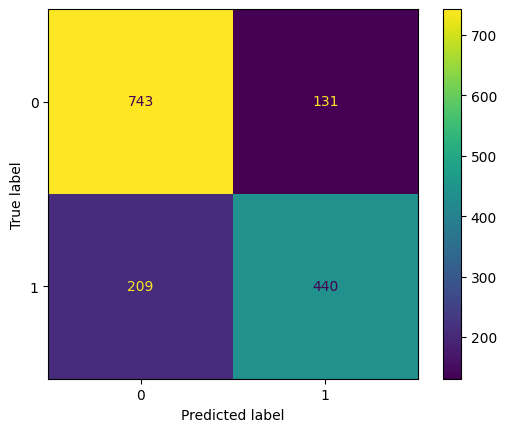

In [105]:
print(f"Accuracy: {accuracy_score(y_test,preds)}")
print(f"F1 score: {f1_score(y_test,preds)}")
print(f"Recall score: {recall_score(y_test,preds)}")
cm = confusion_matrix(y_test, preds)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
plt.show()

### Support Vector Machines

In [107]:
clf = SVC()
params = {
    'kernel' : ['linear', 'poly', 'rbf']
}
gs_clf = GridSearchCV(clf,params)
gs_clf.fit(X_train, y_train)
model = gs_clf.best_estimator_
model.fit(X_train, y_train)
preds = model.predict(X_test)

For model: SVC()
Accuracy: 0.7846355876559422
F1 score: 0.732463295269168
Recall score: 0.6918335901386748


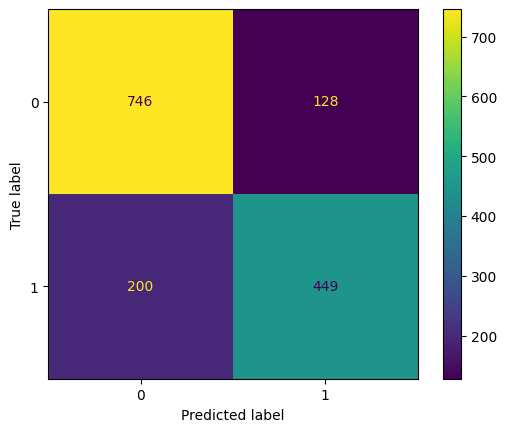

In [109]:
print(f"For model: {model}")
print(f"Accuracy: {accuracy_score(y_test,preds)}")
print(f"F1 score: {f1_score(y_test,preds)}")
print(f"Recall score: {recall_score(y_test,preds)}")
cm = confusion_matrix(y_test, preds)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
plt.show()

### Logistic Regression

In [112]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

For model: LogisticRegression(max_iter=10)
Accuracy: 0.7760998030203545
F1 score: 0.7256637168141593
Recall score: 0.6949152542372882


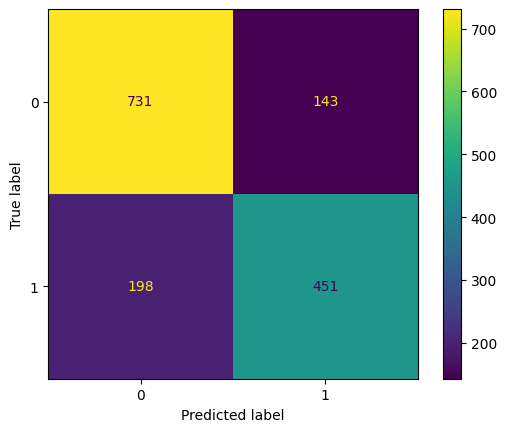

In [114]:
print(f"For model: {model}")
print(f"Accuracy: {accuracy_score(y_test,preds)}")
print(f"F1 score: {f1_score(y_test,preds)}")
print(f"Recall score: {recall_score(y_test,preds)}")
cm = confusion_matrix(y_test, preds)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
plt.show()

### Naive Bayes

In [116]:
model = GaussianNB()
model.fit(X_train, y_train)
preds = model.predict(X_test)

For model: GaussianNB()
Accuracy: 0.6421536441234406
F1 score: 0.6449511400651465
Recall score: 0.7627118644067796


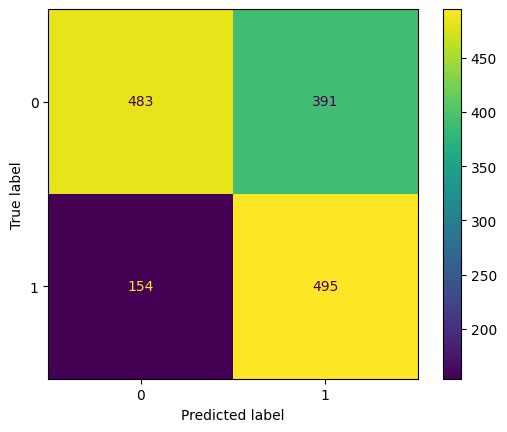

In [117]:
print(f"For model: {model}")
print(f"Accuracy: {accuracy_score(y_test,preds)}")
print(f"F1 score: {f1_score(y_test,preds)}")
print(f"Recall score: {recall_score(y_test,preds)}")
cm = confusion_matrix(y_test, preds)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
plt.show()

### KNeighborsClassifier

In [123]:
clf = KNeighborsClassifier()
params = {
    'n_neighbors' : list(range(3,11))
}
gs_clf = GridSearchCV(clf,params)
gs_clf.fit(X_train, y_train)
model = gs_clf.best_estimator_
model.fit(X_train, y_train)
preds = model.predict(X_test)

For model: KNeighborsClassifier(n_neighbors=10)
Accuracy: 0.6887721602101117
F1 score: 0.5878260869565217
Recall score: 0.5208012326656395


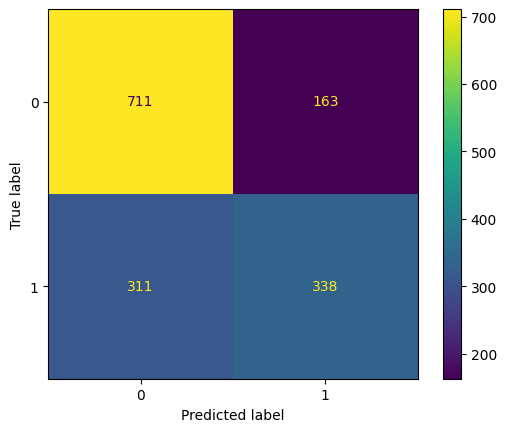

In [124]:
print(f"For model: {model}")
print(f"Accuracy: {accuracy_score(y_test,preds)}")
print(f"F1 score: {f1_score(y_test,preds)}")
print(f"Recall score: {recall_score(y_test,preds)}")
cm = confusion_matrix(y_test, preds)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
plt.show()

### Decision Tree Classifier

In [126]:
clf = DecisionTreeClassifier()
params = {'criterion': ['gini', 'entropy'],
        'max_depth': list(range(1,12))
        }
gs_clf = GridSearchCV(clf,params)
gs_clf.fit(X_train, y_train)
model = gs_clf.best_estimator_
model.fit(X_train, y_train)
preds = model.predict(X_test)

For model: DecisionTreeClassifier(max_depth=8)
Accuracy: 0.680236375574524
F1 score: 0.5917854149203688
Recall score: 0.5439137134052389


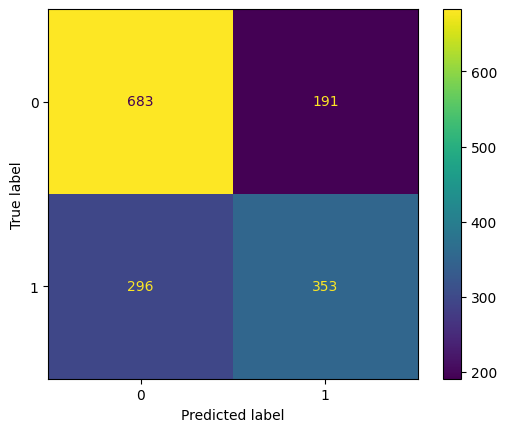

In [127]:
print(f"For model: {model}")
print(f"Accuracy: {accuracy_score(y_test,preds)}")
print(f"F1 score: {f1_score(y_test,preds)}")
print(f"Recall score: {recall_score(y_test,preds)}")
cm = confusion_matrix(y_test, preds)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
plt.show()

### Random Forest Classifier

In [134]:
clf = RandomForestClassifier()
params = {
        'max_depth': list(range(1,10)),
         'n_estimators': [1,10,100]
        }
gs_clf = GridSearchCV(clf,params)
gs_clf.fit(X_train, y_train)
model = gs_clf.best_estimator_
model.fit(X_train, y_train)
preds = model.predict(X_test)

For model: RandomForestClassifier(max_depth=9)
Accuracy: 0.7859487852921865
F1 score: 0.7223168654173765
Recall score: 0.6533127889060092


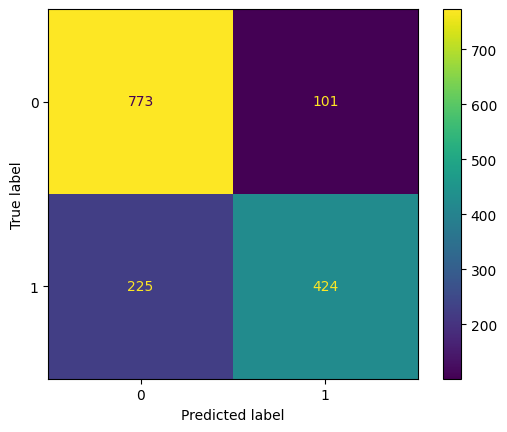

In [135]:
print(f"For model: {model}")
print(f"Accuracy: {accuracy_score(y_test,preds)}")
print(f"F1 score: {f1_score(y_test,preds)}")
print(f"Recall score: {recall_score(y_test,preds)}")
cm = confusion_matrix(y_test, preds)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
plt.show()

# Interpretation and Application

### The accuracies for each model descendingly: 
#### RandomForestClassifier(max_depth=9): 0.7859487852921865
#### Support vector machine - SVC(): 0.7846355876559422
#### Neural Network model: 0.7767564018384767
#### LogisticRegression(max_iter=10): 0.7760998030203545
#### KNeighborsClassifier(n_neighbors=10): 0.6887721602101117
#### DecisionTreeClassifier(max_depth=8): 0.680236375574524
#### Naive Bayes - GaussianNB(): 0.6421536441234406

#### Accurate classification of disaster-related tweets can enhance real-time response by prioritizing and categorizing emergency information.
#### These models can be integrated into disaster management systems to filter and analyze social media content, providing actionable insights and improving overall response efficiency.

# Analyzing Disaster-Related Tweets

## Project Overview
### This project aims to analyze tweets related to disasters using various machine learning models. The dataset includes tweets with features such as keywords, location, and text, and the task is to classify tweets into categories indicating disaster-related or not.

## Data Preprocessing

### Data Loading and Cleaning:
#### Loaded data from train.csv.
#### Dropped the id column.
#### Filled missing values in keyword and location columns with the mode of the respective column.

### Text Cleaning:
#### Removed URLs, HTML tags, and special characters from keyword, location, and text columns.
#### Converted text to lowercase and removed stopwords.
#### Applied stemming and lemmatization.

### Feature Engineering:
#### Used pre-trained Word2Vec embeddings to convert text data into numerical format.
#### Created embedding columns for categorical text features using Word2Vec.

### Data Splitting:
#### Split the dataset into training and testing sets with a test size of 20%.

## Model Training and Tuning
### Neural Network (NN):
#### Determined the optimal number of hidden layers, epochs, and batch size through iterative training and evaluation.
#### Final model: 1 hidden layer with 100 units, 100 epochs, and batch size of 40.

### Support Vector Machine (SVM):
#### Tuned kernel type using GridSearchCV.
#### Final model: SVM with the best kernel based on cross-validation.

### Logistic Regression:
#### Trained and evaluated using default parameters.

### Naive Bayes:
#### Trained using GaussianNB.

### K-Nearest Neighbors (KNN):
#### Tuned n_neighbors using GridSearchCV.
#### Final model: KNN with the best n_neighbors value (n_neighbors=10).

### Decision Tree:
#### Tuned criterion and max_depth using GridSearchCV.
#### Final model: Decision Tree with the best parameters (max_depth=8).

### Random Forest:
#### Tuned max_depth and n_estimators using GridSearchCV.
#### Final model: Random Forest with the best parameters (max_depth=9).

## Model Evaluation
### Metrics Used:
#### Accuracy
#### F1 Score
#### Recall Score
#### Confusion Matrix
#### Evaluation Results:

### Neural Network:
#### Accuracy: 0.7767564018384767
#### F1 score: 0.7213114754098361
#### Recall score: 0.6779661016949152

### SVM:
#### Accuracy: 0.7846355876559422
#### F1 score: 0.732463295269168
#### Recall score: 0.6918335901386748

### Logistic Regression:
#### Accuracy: 0.7760998030203545
#### F1 score: 0.7256637168141593
#### Recall score: 0.6949152542372882

### Naive Bayes:
#### Accuracy: 0.6421536441234406
#### F1 score: 0.6449511400651465
#### Recall score: 0.7627118644067796

### K-Nearest Neighbors:
#### Accuracy: 0.6887721602101117
#### F1 score: 0.5878260869565217
#### Recall score: 0.5208012326656395

### Decision Tree:
#### Accuracy: 0.680236375574524
#### F1 score: 0.5917854149203688
#### Recall score: 0.5439137134052389

### Random Forest:
#### Accuracy: 0.7859487852921865
#### F1 score: 0.7223168654173765
#### Recall score: 0.6533127889060092

## Summary of Findings
### Best Performing Model:
#### Random Forest and Support vector machine showed the highest accuracy indicating they are the most effective models for this classification task.

### Model Performance:
#### Random Forest and Support vector machine models performed better in terms of accuracy and F1 score compared to other models.
#### Neural Network and Logistic Regression also showed strong performance but slightly lower than Random Forest and Support vector machine.

### Impact on Disaster Response Strategies:
#### Accurate classification of disaster-related tweets can enhance real-time response by prioritizing and categorizing emergency information.
#### These models can be integrated into disaster management systems to filter and analyze social media content, providing actionable insights and improving overall response efficiency.

## Recommendations
### Model Selection:
#### Random Forest and Support vector machine are recommended for deployment due to their superior performance.